# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [ ]:
!pip install -r requirements.txt

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from config import CFG

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CFG.MEAN, CFG.STD)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CFG.MEAN, CFG.STD)
])

if os.path.exists(CFG.DATA_DIR):
    training_set = torchvision.datasets.CIFAR10(root=CFG.DATA_DIR, train=True, download=False, transform=train_transform)
    testing_set = torchvision.datasets.CIFAR10(root=CFG.DATA_DIR, train=False, download=False, transform=test_transform)
else:
    training_set = torchvision.datasets.CIFAR10(root=CFG.DATA_DIR, train=True, download=True, transform=train_transform)
    testing_set = torchvision.datasets.CIFAR10(root=CFG.DATA_DIR, train=False, download=True, transform=test_transform)

train_set, val_set = torch.utils.data.random_split(training_set, [40000, 10000])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(testing_set, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

print('Training set size:', len(training_set))
print('Validation set size:', len(val_set))
print('Test set size:', len(testing_set))

Training set size: 50000
Validation set size: 10000
Test set size: 10000


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show_five_images(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(CFG.CLASSES[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

# Visualize images in the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse


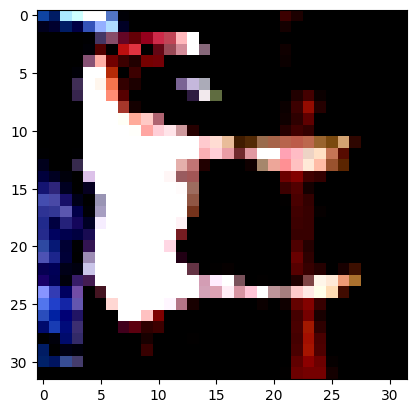

frog


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


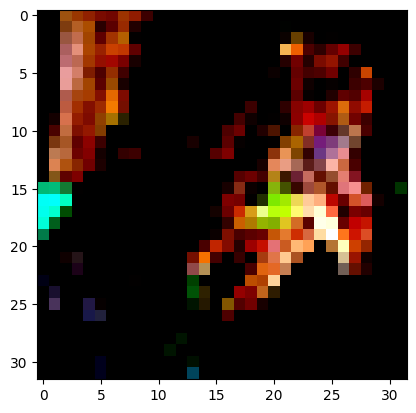

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


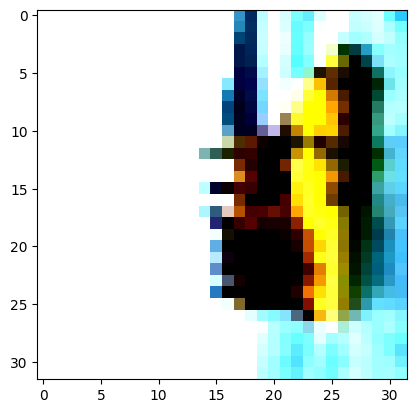

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


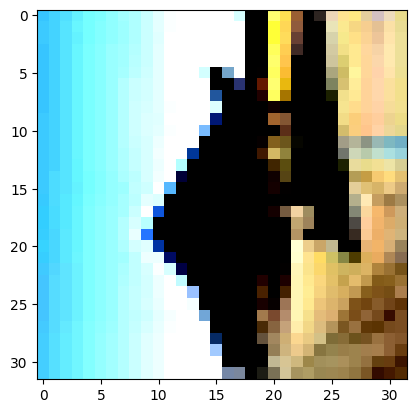

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck


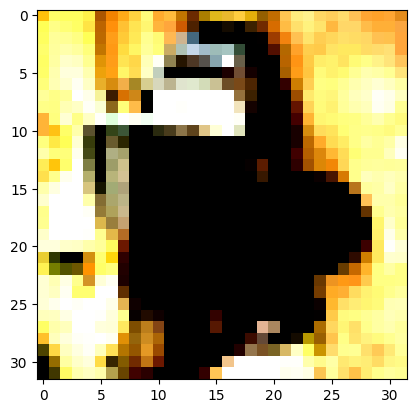

In [4]:
show_five_images(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


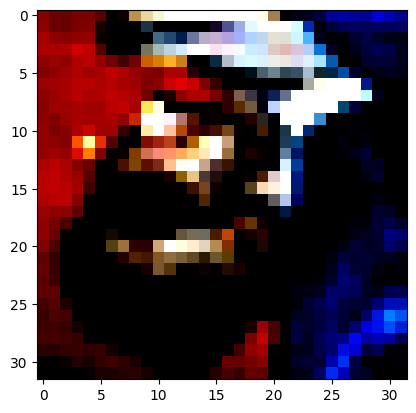

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


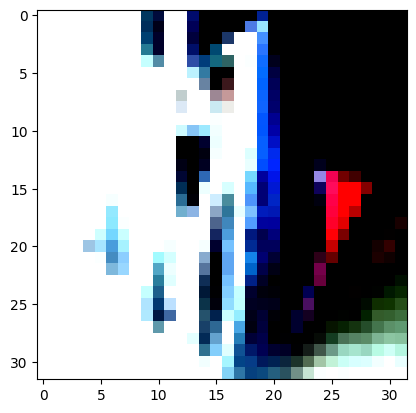

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


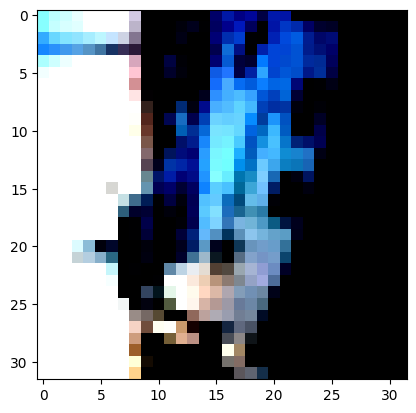

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane


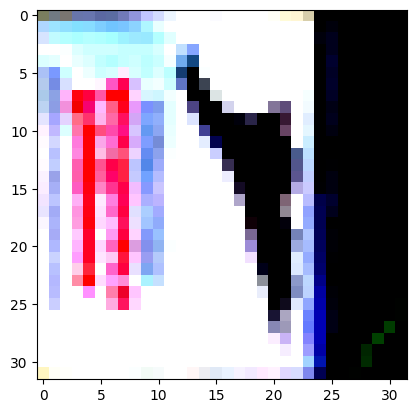

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frog


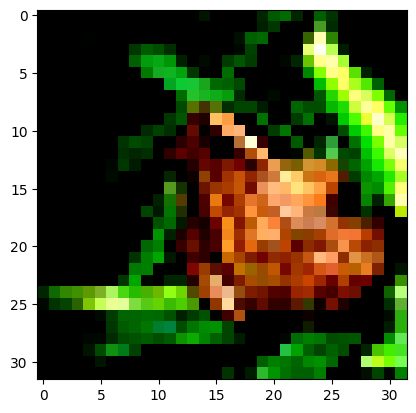

In [5]:
show_five_images(test_loader)

In [6]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([32, 3, 32, 32])
torch.Size([32])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1024*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.softmax(self.fc4(x), dim=1)
        
        return x

In [8]:
model = Network()
print(model)

Network(
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=CFG.LEARNING_RATE)
train_losses, val_losses = [], []

for e in range(CFG.EPOCHS):
    train_running_loss = 0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)
        images = images.to(CFG.DEVICE)
        labels = labels.to(CFG.DEVICE)
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    else:
        val_running_loss = 0
        val_correct = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                images = images.to(CFG.DEVICE)
                labels = labels.to(CFG.DEVICE)
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                val_running_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                val_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = train_running_loss / len(train_loader.dataset)
        val_loss = val_running_loss / len(val_loader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(
            "Epoch: {}/{} | ".format(e+1, CFG.EPOCHS),
            "Training Loss: {:.3f} | ".format(train_loss),
            "Val Loss: {:.3f} | ".format(val_loss),
            "Val Accuracy: {:.3f}".format(val_correct / len(val_loader.dataset))
        )

Epoch: 1/20 |  Training Loss: 0.070 |  Val Loss: 0.068 |  Val Accuracy: 0.271
Epoch: 2/20 |  Training Loss: 0.067 |  Val Loss: 0.066 |  Val Accuracy: 0.351
Epoch: 3/20 |  Training Loss: 0.065 |  Val Loss: 0.065 |  Val Accuracy: 0.376
Epoch: 4/20 |  Training Loss: 0.065 |  Val Loss: 0.064 |  Val Accuracy: 0.398
Epoch: 5/20 |  Training Loss: 0.064 |  Val Loss: 0.064 |  Val Accuracy: 0.409
Epoch: 6/20 |  Training Loss: 0.064 |  Val Loss: 0.064 |  Val Accuracy: 0.421
Epoch: 7/20 |  Training Loss: 0.064 |  Val Loss: 0.064 |  Val Accuracy: 0.420
Epoch: 8/20 |  Training Loss: 0.063 |  Val Loss: 0.063 |  Val Accuracy: 0.441
Epoch: 9/20 |  Training Loss: 0.063 |  Val Loss: 0.063 |  Val Accuracy: 0.431
Epoch: 10/20 |  Training Loss: 0.063 |  Val Loss: 0.063 |  Val Accuracy: 0.441
Epoch: 11/20 |  Training Loss: 0.063 |  Val Loss: 0.063 |  Val Accuracy: 0.442
Epoch: 12/20 |  Training Loss: 0.062 |  Val Loss: 0.063 |  Val Accuracy: 0.436
Epoch: 13/20 |  Training Loss: 0.062 |  Val Loss: 0.063 |  Va

Text(0.5, 1.0, 'Training Process Losses')

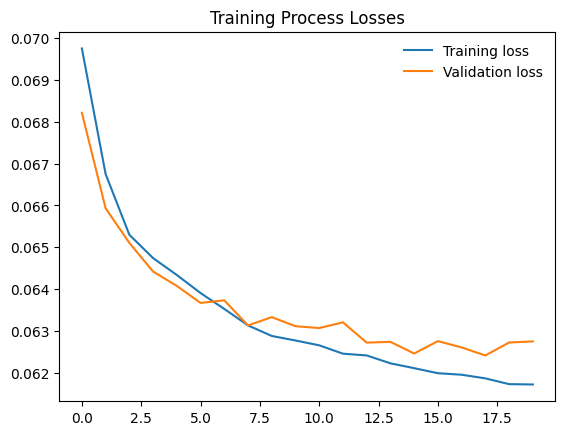

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.title('Training Process Losses')

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
test_correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)
        images = images.to(CFG.DEVICE)
        labels = labels.to(CFG.DEVICE)
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_correct += equals.sum().item()

print(
    "Test Accuracy: {:.3f}".format(test_correct / len(test_loader.dataset))
)

Test Accuracy: 0.481


## Inference

In [12]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(list(CFG.CLASSES), size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [13]:
model.eval()
data_iter = iter(test_loader)
images, labels = next(data_iter)
img = images[0]
img = img.view(1, 1024*3)

with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

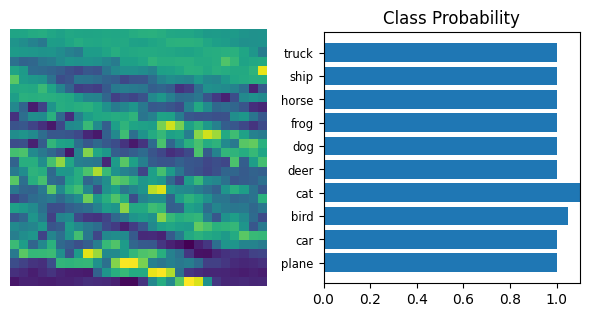

In [14]:
view_classify(img.view(3, 32, 32), ps)

## Saving model
Using `torch.save`, save your model for future loading.

In [15]:
torch.save(model.state_dict(), 'best_cifar10_checkpoint.pth')

## Load model inference

In [16]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network()
    model.load_state_dict(checkpoint)
    model.eval()
    return model

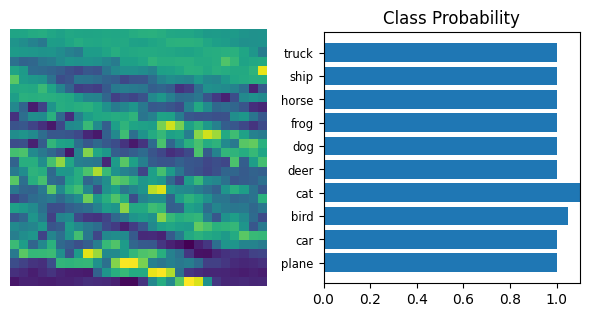

In [17]:
loaded_model = load_checkpoint('best_cifar10_checkpoint.pth')
loaded_model.forward(img)
ps = torch.exp(output)
view_classify(img.view(3, 32, 32), ps)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Recommendation:
- I would recommend to use pre-trained model for this task. The reason is that the accuracy of the model is very high and it is very difficult to achieve this accuracy with a custom model. Also, the pre-trained model is already trained on a large dataset and it is very difficult to train a model on such a large dataset. So, it is better to use a pre-trained model for this task.
- Visualize more images in the dataset and try more data augmentation techniques to improve the accuracy of the model.
- Try different learning rates and different optimizers to improve the accuracy of the model.